In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.mixture import BayesianGaussianMixture
import lightgbm as lgb
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-jul-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-jul-2022/data.csv


In [2]:
data = pd.read_csv("/kaggle/input/tabular-playground-series-jul-2022/data.csv")
sub = pd.read_csv("/kaggle/input/tabular-playground-series-jul-2022/sample_submission.csv")

In [3]:
data.head()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,0,-0.389420,-0.912791,0.648951,0.589045,-0.830817,0.733624,2.258560,2,13,...,-0.478412,-0.757002,-0.763635,-1.090369,1.142641,-0.884274,1.137896,1.309073,1.463002,0.813527
1,1,-0.689249,-0.453954,0.654175,0.995248,-1.653020,0.863810,-0.090651,2,3,...,-0.428791,-0.089908,-1.784204,-0.839474,0.459685,1.759412,-0.275422,-0.852168,0.562457,-2.680541
2,2,0.809079,0.324568,-1.170602,-0.624491,0.105448,0.783948,1.988301,5,11,...,-0.413534,-1.602377,1.190984,3.267116,-0.088322,-2.168635,-0.974989,1.335763,-1.110655,-3.630723
3,3,-0.500923,0.229049,0.264109,0.231520,0.415012,-1.221269,0.138850,6,2,...,0.619283,1.287801,0.532837,1.036631,-2.041828,1.440490,-1.900191,-0.630771,-0.050641,0.238333
4,4,-0.671268,-1.039533,-0.270155,-1.830264,-0.290108,-1.852809,0.781898,8,7,...,-1.628830,-0.434948,0.322505,0.284326,-2.438365,1.473930,-1.044684,1.602686,-0.405263,-1.987263


In [4]:
sub.head()

,Id,Predicted
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [5]:
data.shape

(98000, 30)

In [6]:
sub.shape

(98000, 2)

**EDA**

In [7]:
data.describe()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
count,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,...,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000
mean,48999.500000,0.001220,0.005580,-0.001042,-0.000700,-0.003522,-0.001612,-0.003042,5.545918,6.763061,...,-0.004513,-0.000515,-0.001670,-0.038752,-0.220002,0.166434,-0.064309,-0.062540,0.098472,-0.230910
std,28290.307527,1.002801,1.000742,1.001373,1.000422,1.003061,1.000532,0.997434,3.691840,4.152348,...,1.004372,1.002962,0.999703,1.477858,1.494836,1.543014,1.576086,1.428055,1.305407,1.528476
min,0.000000,-4.732235,-4.202795,-4.377021,-4.010826,-4.535903,-4.300767,-4.894525,0.000000,0.000000,...,-4.894525,-4.732235,-4.438130,-6.873999,-8.234305,-7.792363,-6.593842,-7.375719,-7.335556,-6.954151
25%,24499.750000,-0.675226,-0.670985,-0.672779,-0.672540,-0.682510,-0.675066,-0.680421,3.000000,4.000000,...,-0.678773,-0.679777,-0.675147,-1.022964,-1.203204,-0.903385,-1.128966,-0.975680,-0.746489,-1.262606
50%,48999.500000,0.002022,0.006650,-0.000324,-0.003185,-0.003307,0.001024,-0.002053,5.000000,6.000000,...,-0.000587,-0.000806,0.000819,-0.056687,-0.219046,0.167074,-0.099221,-0.070852,0.082230,-0.271319
75%,73499.250000,0.677271,0.677746,0.677086,0.672097,0.677589,0.673344,0.668112,8.000000,9.000000,...,0.672149,0.675437,0.676881,0.930158,0.764690,1.217432,0.987684,0.843212,0.925306,0.770516
max,97999.000000,4.490521,4.324974,4.560247,4.399373,4.050549,4.710316,3.998595,32.000000,30.000000,...,4.560247,4.399373,4.135419,6.517721,6.054831,7.527271,7.544731,7.005608,7.205971,6.977150


<AxesSubplot:>

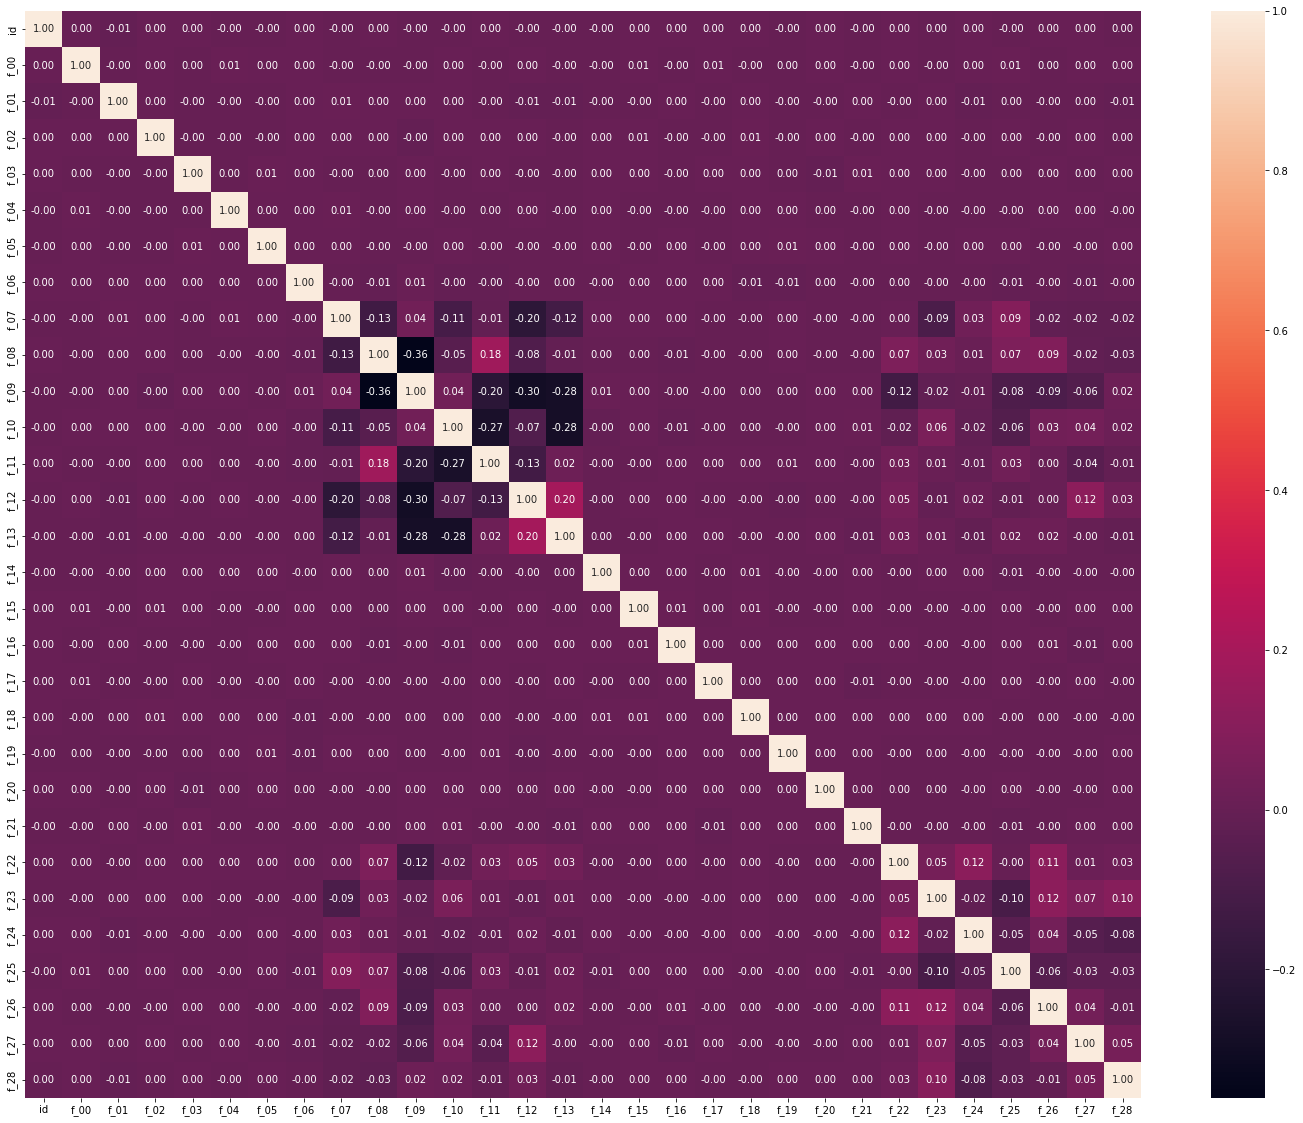

In [8]:
plt.figure(figsize = (25,20))
sns.heatmap(data.corr(),annot = True,fmt = ".2f")

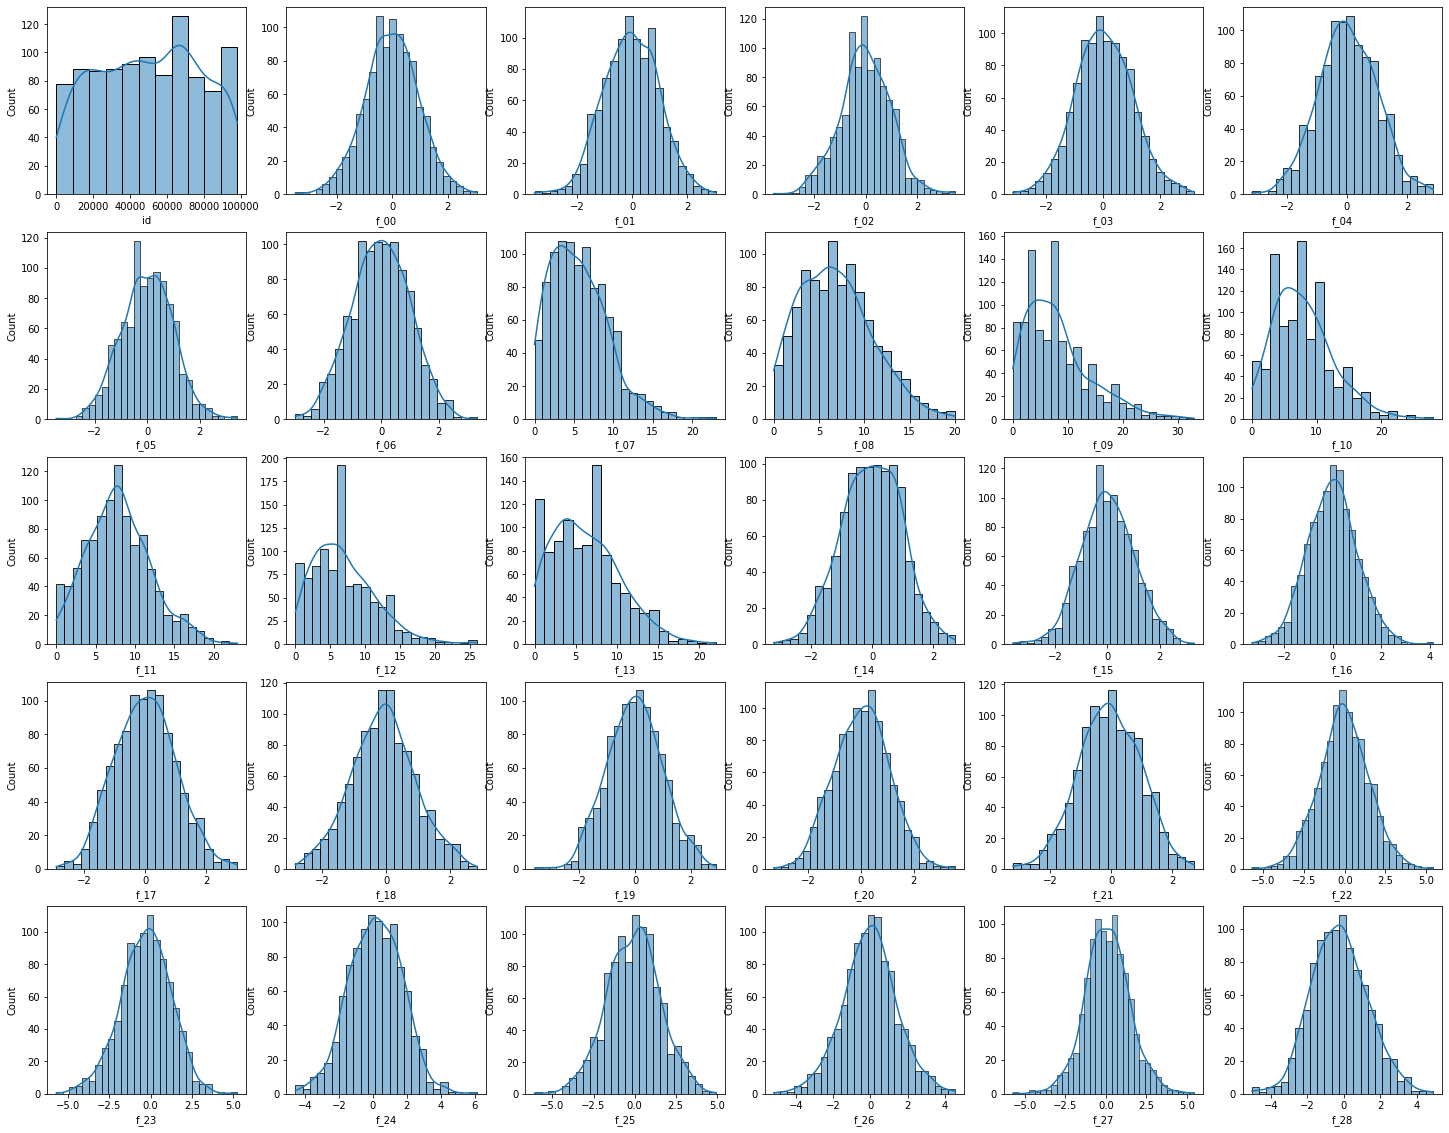

In [9]:
plt.figure(figsize = (25,20))
for i,column in enumerate(list(data.columns),1):
    plt.subplot(5,6,i)
    sns.histplot(x = column,data = data.sample(1000),kde = True)

**Feature Engineering**

In [10]:
data = data.drop(columns = "id")

In [11]:
cols = list(data.columns)

In [12]:
float_cols = data.columns[data.dtypes == 'float']

def iqr_outliers(df,col_list):
    for col in col_list:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3-q1
        Lower_tail = q1 - 2 * iqr
        Upper_tail = q3 + 2 * iqr
        df.loc[df[col] > Upper_tail,col ] = Upper_tail
        df.loc[df[col] < Lower_tail,col] = Lower_tail
    return df


data = iqr_outliers(data,float_cols)

In [13]:
data_scaled = PowerTransformer(method = "yeo-johnson").fit_transform(data)

In [14]:
data_scaled = pd.DataFrame(data_scaled,columns = cols)
data_scaled.head()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,-0.389490,-0.918236,0.648408,0.591081,-0.825423,0.735169,2.260482,-0.977987,1.383372,1.039938,...,-0.473233,-0.754441,-0.763623,-0.709140,0.913092,-0.679616,0.769655,0.966001,1.049870,0.695161
1,-0.688850,-0.459055,0.653646,0.996007,-1.645476,0.865449,-0.085607,-0.977987,-0.875405,-0.179925,...,-0.423866,-0.088151,-1.778899,-0.536545,0.455176,1.032717,-0.118071,-0.553885,0.368716,-1.638216
2,0.806292,0.319483,-1.167772,-0.622838,0.108566,0.785528,1.991400,0.021718,1.017648,-0.394246,...,-0.408685,-1.599894,1.195192,2.207151,0.087821,-1.520665,-0.569596,0.984646,-0.931654,-2.297981
3,-0.500811,0.224007,0.262834,0.234183,0.417435,-1.219615,0.144570,0.286548,-1.213526,0.917564,...,0.620750,1.284657,0.533276,0.732944,-1.221124,0.827435,-1.175115,-0.397119,-0.101764,0.326813
4,-0.670895,-1.045104,-0.271091,-1.834440,-0.286058,-1.850633,0.788045,0.756900,0.187543,-0.394246,...,-1.616212,-0.432656,0.322161,0.228735,-1.486756,0.848970,-0.614918,1.171002,-0.377399,-1.161471


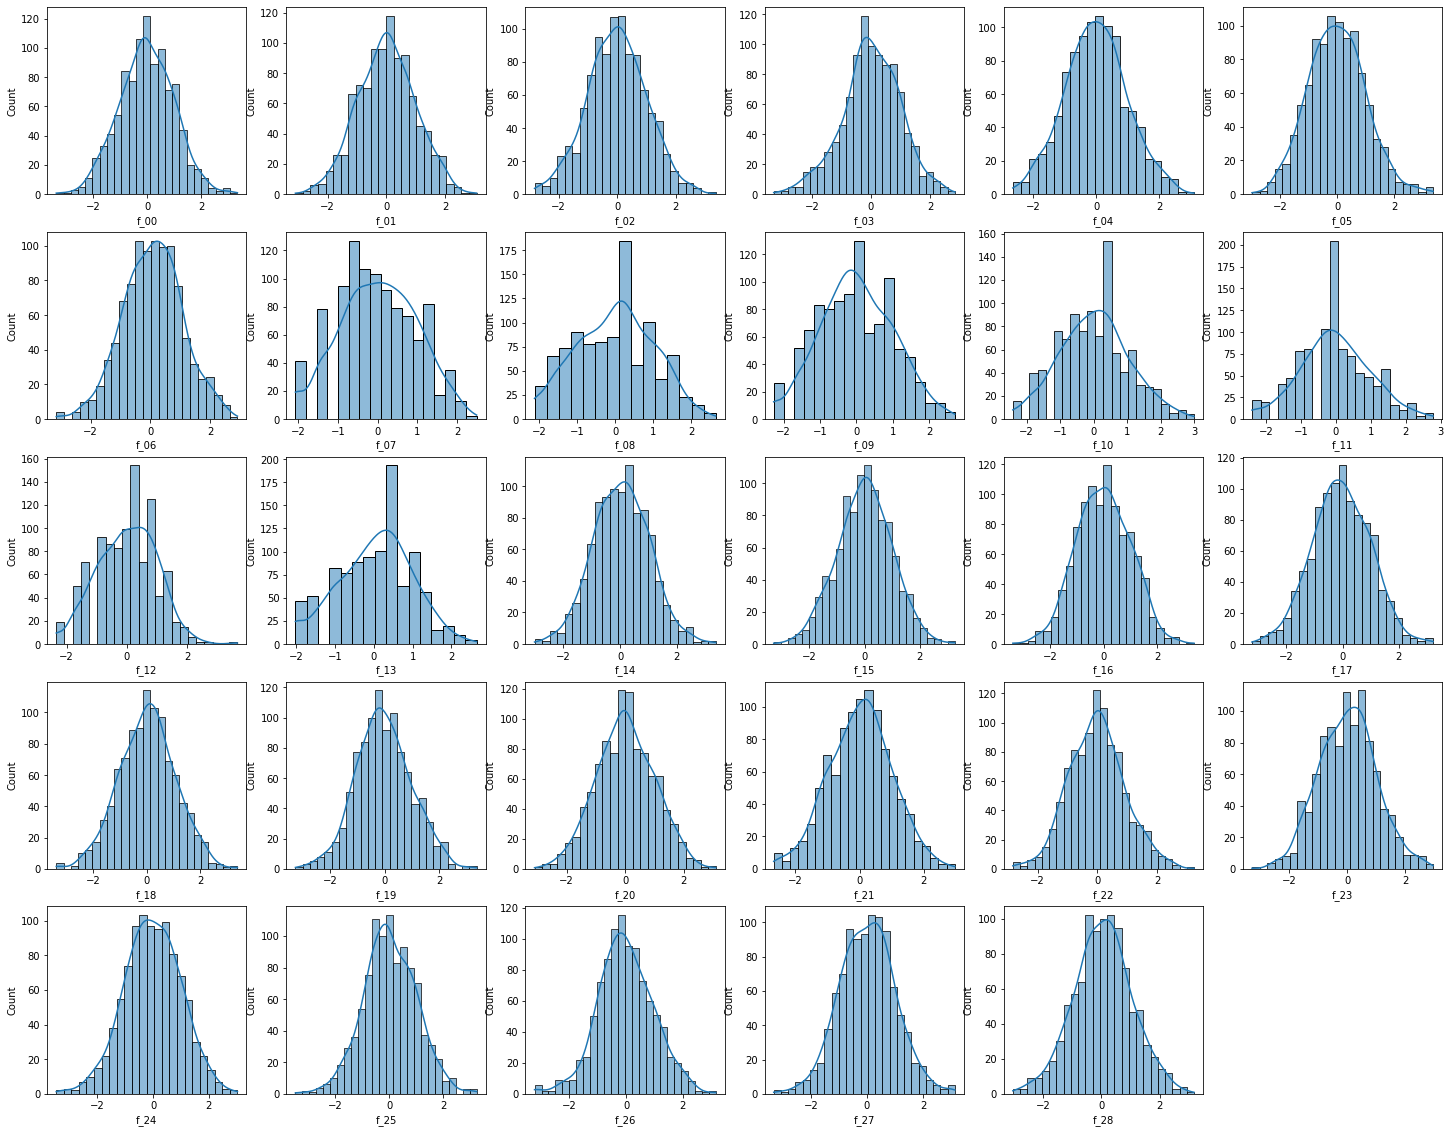

In [15]:
plt.figure(figsize = (25,20))
for i,column in enumerate(list(data_scaled.columns),1):
    plt.subplot(5,6,i)
    sns.histplot(x = column,data=data_scaled.sample(1000),kde = True)

**Model**

BayesianGaussianMixture

In [16]:
vbgmm = BayesianGaussianMixture(n_components = 7,covariance_type = 'full',random_state = 1)
preds = vbgmm.fit_predict(data_scaled)

/opt/conda/lib/python3.7/site-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


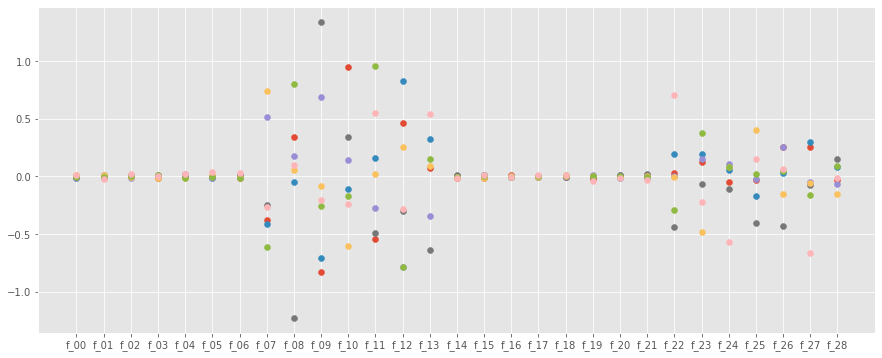

In [17]:
plt.style.use('ggplot')
plt.figure(figsize = (15,6))
for i in range(vbgmm.means_.shape[0]):
    plt.scatter(np.arange(data_scaled.shape[1]), vbgmm.means_[i])
plt.xticks(ticks = np.arange(data_scaled.shape[1]), labels=cols)
plt.show()

In [18]:
important_cols = ['f_07', 'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27', 'f_28', ]

In [19]:
preds_vbgmm = vbgmm.fit_predict(data_scaled[important_cols])

In [20]:
pp = vbgmm.predict_proba(data_scaled[important_cols])

In [21]:
data_scaled[[f'predict_proba_{i}' for i in range(7)]] = pp 
data_scaled['predict_proba'] = np.max(pp,axis=1)
data_scaled['predict'] = np.argmax(pp,axis=1)
data_scaled

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_28,predict_proba_0,predict_proba_1,predict_proba_2,predict_proba_3,predict_proba_4,predict_proba_5,predict_proba_6,predict_proba,predict
0,-0.389490,-0.918236,0.648408,0.591081,-0.825423,0.735169,2.260482,-0.977987,1.383372,1.039938,...,0.695161,0.003538,0.977097,0.000430,0.002441,0.013155,4.903173e-07,3.338810e-03,0.977097,1
1,-0.688850,-0.459055,0.653646,0.996007,-1.645476,0.865449,-0.085607,-0.977987,-0.875405,-0.179925,...,-1.638216,0.018709,0.000312,0.003429,0.027759,0.935196,1.458609e-02,9.294264e-06,0.935196,4
2,0.806292,0.319483,-1.167772,-0.622838,0.108566,0.785528,1.991400,0.021718,1.017648,-0.394246,...,-2.297981,0.000105,0.817560,0.001512,0.000017,0.000311,1.029774e-08,1.804953e-01,0.817560,1
3,-0.500811,0.224007,0.262834,0.234183,0.417435,-1.219615,0.144570,0.286548,-1.213526,0.917564,...,0.326813,0.000054,0.000016,0.027537,0.010946,0.013686,8.566568e-01,9.110418e-02,0.856657,5
4,-0.670895,-1.045104,-0.271091,-1.834440,-0.286058,-1.850633,0.788045,0.756900,0.187543,-0.394246,...,-1.161471,0.000184,0.000005,0.979811,0.000003,0.019988,9.032280e-07,8.657991e-06,0.979811,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97995,0.236270,1.650468,-0.688865,0.316277,-0.294967,0.330464,1.611862,0.021718,0.187543,0.191659,...,0.459907,0.003075,0.014397,0.093641,0.222287,0.483896,1.246589e-03,1.814573e-01,0.483896,4
97996,0.321173,0.705051,0.561859,-1.322966,-0.353494,0.183298,0.184362,-0.598123,0.622133,-1.243439,...,0.640535,0.009413,0.000693,0.420903,0.536872,0.032101,1.225533e-08,1.799766e-05,0.536872,3
97997,-0.249678,-0.464649,1.891551,-1.341658,0.197943,-0.558212,-0.376015,0.756900,0.622133,0.509344,...,0.585604,0.001130,0.006323,0.033271,0.000296,0.008290,8.539646e-05,9.506054e-01,0.950605,6
97998,0.309912,2.177752,0.761159,0.439091,0.467280,0.063567,-0.330040,-1.440987,0.410491,0.653205,...,0.128873,0.702475,0.000539,0.000415,0.036373,0.083146,4.037650e-02,1.366747e-01,0.702475,0


In [22]:
tr_idx = np.array([])
for n in range(7):
    idx = data_scaled[(data_scaled["predict"] == n) & (data_scaled["predict_proba"] > 0.80)].index 
    tr_idx = np.concatenate((tr_idx, idx))
    
X = data_scaled.loc[tr_idx][important_cols]
y = data_scaled.loc[tr_idx]['predict']

In [23]:
X.head()

,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_22,f_23,f_24,f_25,f_26,f_27,f_28
27.0,0.021718,1.203800,-0.635157,2.238616,0.517399,-0.928325,0.317221,0.612354,-0.308780,-1.254006,1.091906,-1.925773,0.440356,-0.603666
28.0,-0.598123,1.888883,-0.912475,1.054360,-0.171515,0.755755,-0.735370,-0.298961,-0.571635,-1.416830,1.051979,0.302921,-1.591170,0.516079
33.0,0.530261,-0.048856,-0.912475,1.531077,-0.682876,0.936024,-0.162832,0.027068,0.218462,-2.075317,0.831600,0.852856,0.142502,1.021615
36.0,0.530261,0.622133,-0.394246,2.104246,-0.682876,0.565556,0.533888,-0.026403,0.155426,-3.186020,2.217523,1.927069,0.042967,-0.956272
55.0,-0.270117,1.557045,-1.243439,1.054360,-0.682876,0.148356,0.086073,-0.096195,-0.720080,0.329862,-0.587878,-0.128239,-0.575461,-1.631616


In [24]:
y

27.0       0
28.0       0
33.0       0
36.0       0
55.0       0
          ..
97983.0    6
97984.0    6
97987.0    6
97993.0    6
97997.0    6
Name: predict, Length: 62500, dtype: int64

LightGBM

In [25]:
lgbm_predict_proba = 0 
kf = StratifiedKFold(5, shuffle = True, random_state = 1)

for fold, (tr_idx, val_idx) in enumerate(kf.split(X,y)):   
    print("*****Fold {}*****".format(fold+1))
    tr_X,val_X = X.iloc[tr_idx],X.iloc[val_idx]
    tr_y,val_y = y.iloc[tr_idx],y.iloc[val_idx]
    
    lgb_train = lgb.Dataset(tr_X,tr_y)
    lgb_eval = lgb.Dataset(val_X,val_y)
    
    params = {'learning_rate': 0.07,
              'objective': 'multiclass',
              "metric" : "multi_logloss",
              'boosting': 'gbdt',
              'verbosity': -1,
              'n_jobs': -1,
              'num_classes':7} 
    
    model = lgb.train(params, 
                      lgb_train,
                      valid_sets = [lgb_train,lgb_eval],
                      num_boost_round = 5000, 
                      callbacks = [ lgb.early_stopping(stopping_rounds = 100, verbose = True), lgb.log_evaluation(period = 100)])  

    lgbm_predict_proba += model.predict(data_scaled[important_cols])

preds = np.argmax(lgbm_predict_proba/5,axis=1)

*****Fold 1*****
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0234352	valid_1's multi_logloss: 0.0506974
[200]	training's multi_logloss: 0.00266255	valid_1's multi_logloss: 0.0232896
[300]	training's multi_logloss: 0.000401389	valid_1's multi_logloss: 0.0172981
[400]	training's multi_logloss: 6.6545e-05	valid_1's multi_logloss: 0.0154229
[500]	training's multi_logloss: 1.13753e-05	valid_1's multi_logloss: 0.0149553
[600]	training's multi_logloss: 2.30401e-06	valid_1's multi_logloss: 0.015218
Early stopping, best iteration is:
[527]	training's multi_logloss: 7.12661e-06	valid_1's multi_logloss: 0.0148747
*****Fold 2*****
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0229475	valid_1's multi_logloss: 0.0529767
[200]	training's multi_logloss: 0.00258731	valid_1's multi_logloss: 0.0228799
[300]	training's multi_logloss: 0.000388973	valid_1's multi_logloss: 0.0160018
[400]	training's multi_lo

**Submission**

In [26]:
sub["Predicted"] = preds

In [27]:
sub.to_csv('submission.csv', index=False)